In [1]:
import os
import json
import tqdm
import torch
import math
from mace.calculators import MACECalculator

import ase
from ase import Atoms
from ase.io import read, write, Trajectory

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from ase.md import MDLogger
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase.md.nvtberendsen import NVTBerendsen

## Runnning a test MD simulation

In [5]:
# BASE_PATH = "/usr/workspace/dsk-jv/mace/models/normal/3BPA_500/checkpoints"
BASE_PATH = "/usr/workspace/dsk-jv/trained_models/mace/v2_l2"

calc = MACECalculator(f"{BASE_PATH}/deployed.pth", device="cuda", default_dtype="float32")
# calc = MACECalculator(BASE_PATH, device="cuda:3", default_dtype="float32")

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
xyz = read("/usr/workspace/dsk-jv/mace/datasets/3BPA_500.xyz", index=":")

In [ ]:
energies = [at.info["energy"] for at in xyz]
atoms = [at for at in xyz if at.info["energy"] == min(energies)][0].copy()
atoms.set_calculator(calc)

In [ ]:
atoms.get_forces()

In [8]:
temperature = 600 # Kelvin
timestep = 1 * ase.units.fs
taut = 0.5 * 500 * ase.units.fs

dyn = NVTBerendsen(
    atoms,
    timestep=timestep,
    temperature_K=temperature,
    taut=taut,
    trajectory="3BPA-MACE.traj",
)

In [9]:
dyn.attach(MDLogger(
    dyn,
    atoms,
    '3BPA-MACE.log',
    header=True,
    stress=False,
    peratom=True,
    mode="a"
), interval=3)

In [10]:
dyn.run(1000)

/usr/workspace/dskoda/envs/torch-coral/lib/python3.8/site-packages/ase/md/nvtberendsen.py:95: RuntimeWarning: divide by zero encountered in double_scalars
  (self.temperature / old_temperature - 1.0) *
/usr/workspace/dskoda/envs/torch-coral/lib/python3.8/site-packages/e3nn/o3/_spherical_harmonics.py:82: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at  /usr/WS1/dskoda/envs/torch-setup/pytorch/torch/csrc/jit/codegen/cuda/manager.cpp:334.)
  sh = _spherical_harmonics(self._lmax, x[..., 0], x[..., 1], x[..., 2])
/usr/workspace/dskoda/envs/torch-coral/lib/python3.8/site-packages/torch/autograd/__init__.py:276: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback

## Analyzing the trajectory

In [2]:
from ase.geometry.analysis import Analysis

In [3]:
def get_edge_list(atoms):
    an = Analysis(atoms)
    edge_list = []
    for i, bonds in enumerate(an.all_bonds[0]):
        for j in bonds:
            edge_list.append([i, j])

    return np.array(edge_list)

def get_distances(atoms, edge_list=None):
    dm = atoms.get_all_distances()
    if edge_list is None:
        return dm
    
    return dm[edge_list[:, 0], edge_list[:, 1]]    

In [7]:
def get_explosion_index(traj):
    edges = get_edge_list(traj[0])
    
    max_dists = np.array([
        get_distances(at, edges).max()
        for at in traj
    ])
    index = np.argwhere(max_dists > 2).flat
    if len(index) == 0:
        return len(traj)
    
    return index[0]

## Analyzing all trajectories

In [1]:
import os
import tqdm
import json
import pandas as pd

In [15]:
PATHS = [f"/usr/WS2/dsk-jv/mace/md/runs-{f}" for f in ["2", "3"]]

traj_files = sorted([
    os.path.join(_path, f)
    for _path in PATHS
    for f in os.listdir(_path)
    if f.endswith(".json")
])

In [16]:
results = []

for _json in tqdm.tqdm(traj_files):
    with open(_json, "r") as f:
        traj = json.load(f)
        
    model, i = _json.split("/")[-1].replace(".json", "").split("-")
    traj["model"] = model
    traj["num"] = int(i)

    results.append(traj)

100%|██████████| 448/448 [00:00<00:00, 1574.10it/s]


In [17]:
df = pd.DataFrame(results)

In [18]:
df.to_csv("mace_explosion.csv")

In [19]:
df.model.unique()

array(['baseline', 'non_trainable_bessel',
       'non_trainable_bessel_no_amsgrad_no_ema_no_swa_wc', 'rescaling',
       'v1_l0', 'v2_l0', 'v2_l1',
       'v2_l3_yes_rescaling_no_amsgrad_no_ema_no_swa_wc',
       'v2_l3_yes_rescaling_no_amsgrad_no_ema_yes_swa_wc',
       'v2_l3_yes_rescaling_no_amsgrad_yes_ema_no_swa_wc',
       'v2_l3_yes_rescaling_yes_amsgrad_no_ema_no_swa_wc', 'v3_l3',
       'v1_l3', 'v2_l2', 'v2_l3'], dtype=object)

In [10]:
df.groupby("model").count()

,name,explosion,num
model,,,
baseline,30,30,30
non_trainable_bessel,30,30,30
non_trainable_bessel_no_amsgrad_no_ema_no_swa_wc,29,29,29
rescaling,30,30,30
v1_l0,30,30,30
v1_l3,60,60,60
v2_l0,30,30,30
v2_l1,30,30,30
v2_l2,59,59,59


<Axes: xlabel='model', ylabel='explosion'>

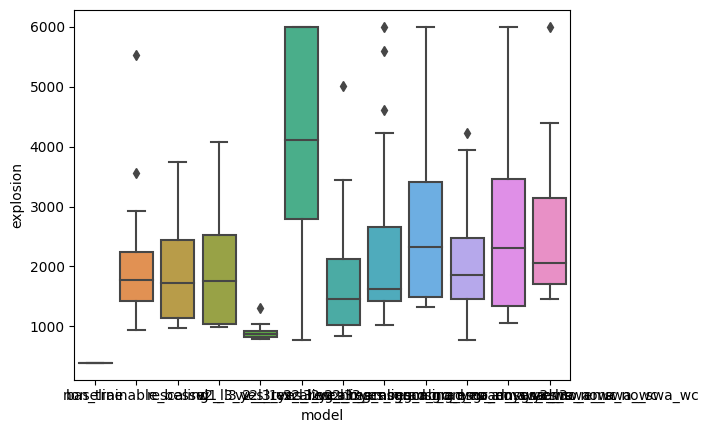

In [20]:
sns.boxplot(
    data=df,
    x="model",
    y="explosion",
)

In [21]:
df["model"].unique()

array(['baseline', 'non_trainable_bessel', 'rescaling', 'v1_l3', 'v2_l1',
       'v2_l2', 'v2_l3',
       'v2_l3_yes_rescaling_no_amsgrad_no_ema_no_swa_wc',
       'v2_l3_yes_rescaling_no_amsgrad_no_ema_yes_swa_wc',
       'v2_l3_yes_rescaling_no_amsgrad_yes_ema_no_swa_wc',
       'v2_l3_yes_rescaling_yes_amsgrad_no_ema_no_swa_wc', 'v3_l3'],
      dtype=object)

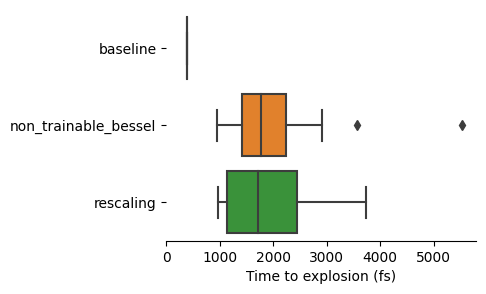

In [22]:
fig, ax = plt.subplots(figsize=(4, 3))

_df = df.loc[df["model"].isin(["baseline", 'non_trainable_bessel', 'rescaling'])]

ax = sns.boxplot(
    data=_df,
    x="explosion",
    y="model",
    ax=ax,
)

ax.set_xlabel("Time to explosion (fs)")
ax.set_ylabel("")

ax.set_xlim(0)

for sp in ["left", "right", "top"]:
    ax.spines[sp].set_visible(False)

plt.show()

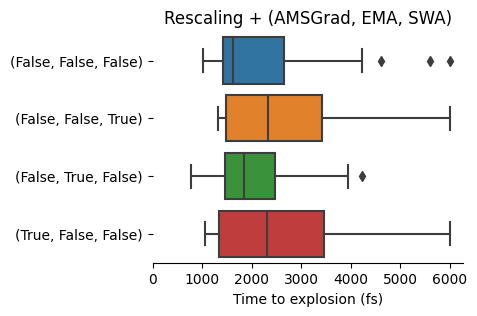

In [31]:
fig, ax = plt.subplots(figsize=(4, 3))

_models = {
    'v2_l3_yes_rescaling_no_amsgrad_no_ema_no_swa_wc': "(False, False, False)",
    'v2_l3_yes_rescaling_no_amsgrad_no_ema_yes_swa_wc': "(False, False, True)",
    'v2_l3_yes_rescaling_no_amsgrad_yes_ema_no_swa_wc': "(False, True, False)",
    'v2_l3_yes_rescaling_yes_amsgrad_no_ema_no_swa_wc': "(True, False, False)",
}
_df = df.loc[df["model"].isin(_models.keys())]

ax = sns.boxplot(
    data=_df,
    x="explosion",
    y="model",
    ax=ax,
)

ax.set_xlabel("Time to explosion (fs)")
ax.set_ylabel("")

ax.set_xlim(0)

for sp in ["left", "right", "top"]:
    ax.spines[sp].set_visible(False)

labels = [_models[t.get_text()] for t in ax.get_yticklabels()]
ax.set_yticklabels(labels)

ax.set_title("Rescaling + (AMSGrad, EMA, SWA)")
plt.show()

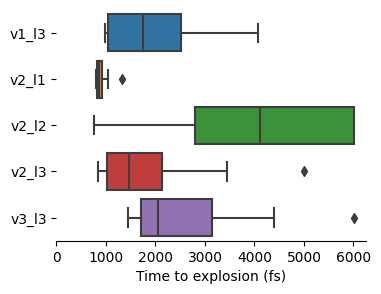

In [32]:
fig, ax = plt.subplots(figsize=(4, 3))

_models = [
    'v1_l3',
    'v2_l1',
    'v2_l2',
    'v2_l3',
    'v3_l3',
]
_df = df.loc[df["model"].isin(_models)]

ax = sns.boxplot(
    data=_df,
    x="explosion",
    y="model",
    ax=ax,
)

ax.set_xlabel("Time to explosion (fs)")
ax.set_ylabel("")

ax.set_xlim(0)

for sp in ["left", "right", "top"]:
    ax.spines[sp].set_visible(False)

# labels = [_models[t.get_text()] for t in ax.get_yticklabels()]
# ax.set_yticklabels(labels)

# ax.set_title("Rescaling + (AMSGrad, EMA, SWA)")
plt.show()